<a href="https://colab.research.google.com/github/2241031c/Night-Lights-Dissertation/blob/main/NL_22_6_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##This notebook will focus on rate of change, time series plotting and SOL for Galloway. The same process is done for Tomintoul using 2018 as a start date.

In [ ]:
#Install Library
!pip install pycrs

In [ ]:
#Import libraries
import json
import pandas as pd

try:
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt

In [ ]:
try:
        ee.Initialize(project='###') #Enter project number (###)
except Exception as e:
        ee.Authenticate()
        ee.Initialize()



In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Time series
Change the date here for:

2014-galloway core

2021- galloway extension

Do these individually to prevent overiding variable names.
Hash out aoi not in use.

In [ ]:
# identify a 500 meter buffer around our Point Of Interest (POI)

poi = ee.Geometry.Point(-4.144, 55.037).buffer(500) #Coordinates and buffer here can be changed for investigative analysis for smaller locations.

#Define AOI by shapefile (c=core area ex=extension)
#galloway_c_shp="/content/drive/MyDrive/NightLight/ArcGIS/Galloway_core/Galloway_core_area.shp"
#aoi_GA_c=geemap.shp_to_ee(galloway_c_shp)

#galloway_ex_shp="/content/drive/MyDrive/NightLight/ArcGIS/Galloway_extension/Galloway_craigengillan_extension.shp"
#aoi_GA_ex=geemap.shp_to_ee(galloway_ex_shp)

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-01-01','2019-12-31') #change dates here accordingly

Extracting all image values in the collection

I'll get the mean of the pixels in our region and set the scale to 30 using the  `avg_rad` band.


In [ ]:
def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30 , maxPixels=90000000).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

In [ ]:
#We map this function to every image in our collection to get a new ImageCollection,
#but now each image has the mean value for the region of interest and the date. These are the data we'll make our time series out of.
poi_reduced_imgs = viirs.map(poi_mean)

In [ ]:
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [ ]:
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

,date,mean
0,2019-01-01T00:00:00,0.372781
1,2019-02-01T00:00:00,0.292204
2,2019-03-01T00:00:00,0.227831
3,2019-04-01T00:00:00,0.266574
4,2019-05-01T00:00:00,0.500495
5,2019-06-01T00:00:00,3.271978
6,2019-07-01T00:00:00,0.959578
7,2019-08-01T00:00:00,0.346046
8,2019-09-01T00:00:00,0.369670
9,2019-10-01T00:00:00,0.351113


In [ ]:
df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')

df

,mean
date,
2019-01-01,0.372781
2019-02-01,0.292204
2019-03-01,0.227831
2019-04-01,0.266574
2019-05-01,0.500495
2019-06-01,3.271978
2019-07-01,0.959578
2019-08-01,0.346046
2019-09-01,0.369670


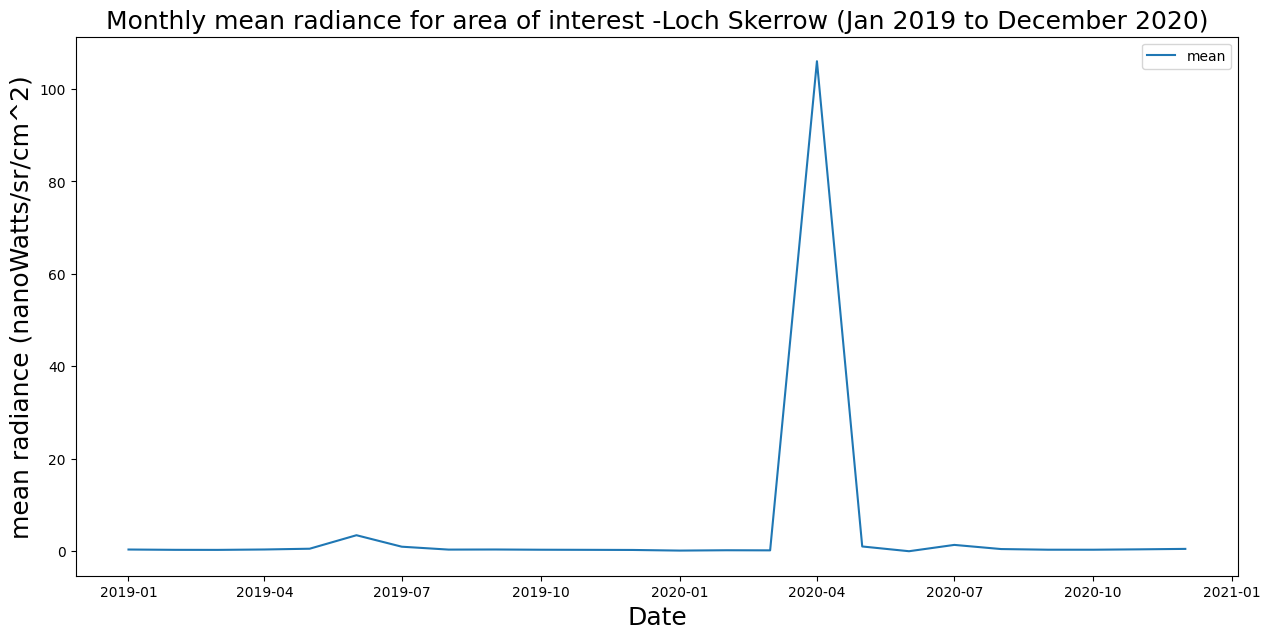

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(15,7))

sns.lineplot(data=df, ax=ax)

# Add axis labels and title
ax.set_ylabel('mean radiance (nanoWatts/sr/cm^2)',fontsize=18)
ax.set_xlabel('Date',fontsize=18)
ax.set_title('Monthly mean radiance for area of interest -Loch Skerrow (Jan 2019 to December 2020)',fontsize=18);

images_dir = '/content/drive/MyDrive/NightLight/Outputs'
#plt.savefig(f"{images_dir}/VIIRS_Monthly_Mean_Radiance_Loch_Skerrow.png") # change save location accordingly

In [ ]:
#identify when the max radiance occurred
df.idxmax()

mean   2020-04-01
dtype: datetime64[ns]

I'll produce a moving avg of 12 months to smooth our data out and see overall trends

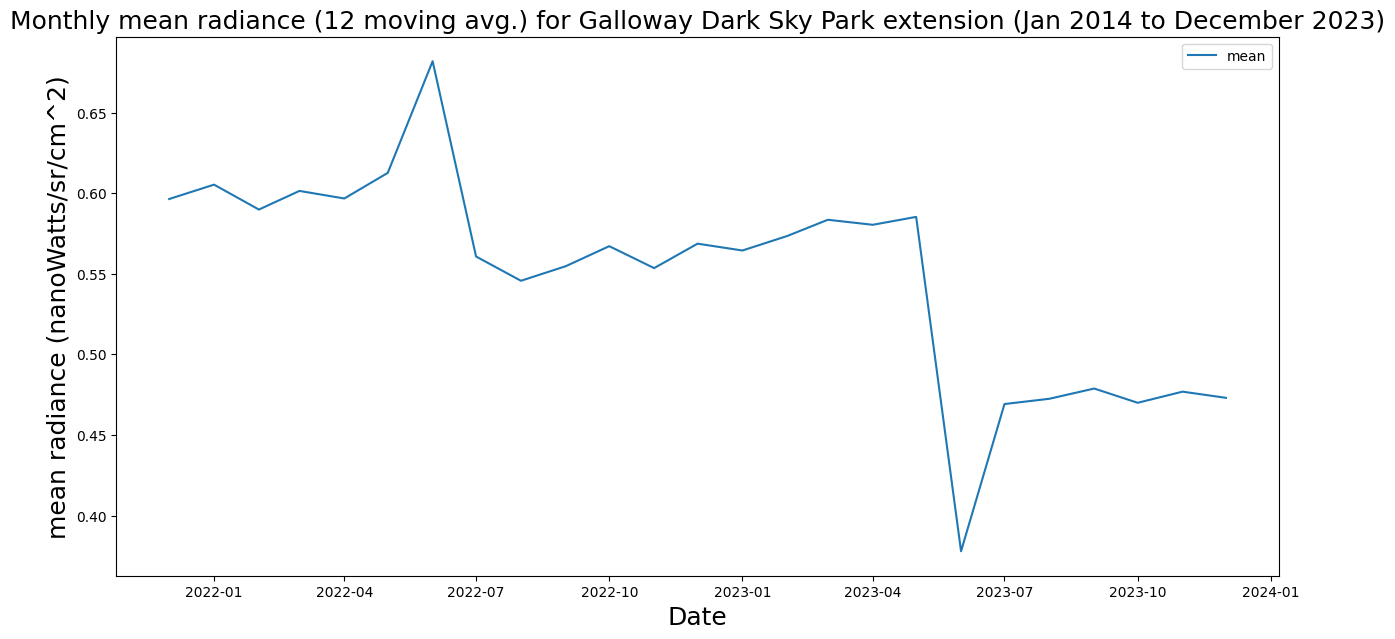

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

window=12
sns.lineplot(data=df.rolling(window).mean(), ax=ax)

# set the labels and title
ax.set_ylabel('mean radiance (nanoWatts/sr/cm^2)',fontsize=18)
ax.set_xlabel('Date',fontsize=18)
ax.set_title(f'Monthly mean radiance ({window} moving avg.) for Galloway Dark Sky Park extension (Jan 2014 to December 2023)',fontsize=18);

images_dir = '/content/drive/MyDrive/NightLight/Outputs'
#plt.savefig(f"{images_dir}/VIIRS_Monthly_Mean_Radiance_Trend_Galloway_extension.png") #change location